# KPIs & Métricas: EDA y Modelado
Este notebook sigue una estructura típica para análisis exploratorio de datos (EDA) y modelado.

# Tabla de Contenido
- [1. Instalación y Librerías](#1-instalación-y-librerías)
- [2. Carga de Datos](#2-carga-de-datos)
- [3. Análisis Exploratorio de Datos (EDA)](#3-análisis-exploratorio-de-datos-eda)
- [4. Preprocesamiento de Datos](#4-preprocesamiento-de-datos)
- [5. Modelado](#5-modelado)
- [6. Interpretación y Conclusiones](#6-interpretación-y-conclusiones)

## 1. Instalación y Librerías
Instalación de dependencias y carga de librerías.

In [106]:
# Install required packages
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [107]:
# --- Importaciones organizadas y sin duplicados ---
import os
import re
import json
import time

import io
import csv


import pandas as pd
import numpy as np
from tqdm import tqdm

from dotenv import load_dotenv

# Data Science & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
from wordcloud import WordCloud

# Machine Learning
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Deep Learning & Generative AI
import torch
import tensorflow as tf
import transformers
import openai
import google.generativeai as genai
from google import genai as google_genai
from google.genai import types

# NLP
import nltk
import spacy

# Data Handling
import openpyxl
from sqlalchemy import create_engine

# APIs & Auth
from googleapiclient.discovery import build
from google.oauth2 import service_account

# Other utilities
import requests
from tenacity import retry

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

## 2. Carga de Datos
Importación de los datos relevantes para el análisis.

In [108]:
import os
import re
import pandas as pd

def limpiar_comas_internas(file_path, temp_path):
    import re
    with open(file_path, 'r', encoding='utf-8') as fin, open(temp_path, 'w', encoding='utf-8') as fout:
        for line in fin:
            # Reemplaza comas entre comillas por punto y coma
            nuevo = re.sub(r'"(.*?)"', lambda m: m.group(0).replace(',', ';'), line)
            fout.write(nuevo)

base_dir = '../EXPORTS'
fecha_regex = re.compile(r'^\d{8}$')
archivos_objetivo = [
    'tbl_conversaciones_conecta2.csv',
    'tbl_encuesta_chat_ia_conecta2.csv',
 ]

dataframes = {}

for archivo in archivos_objetivo:
    dfs = []
    for folder in os.listdir(base_dir):
        if fecha_regex.match(folder):
            file_path = os.path.join(base_dir, folder, archivo)
            temp_path = file_path + '.tmp'
            if os.path.exists(file_path):
                limpiar_comas_internas(file_path, temp_path)
                df = pd.read_csv(temp_path, on_bad_lines='skip')
                df['archivo_origen'] = folder
                dfs.append(df)
                os.remove(temp_path)
    dataframes[archivo] = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

conversaciones_conecta = dataframes['tbl_conversaciones_conecta2.csv']
encuesta_chat_ia_conecta = dataframes['tbl_encuesta_chat_ia_conecta2.csv']

In [109]:
def parsear_csv_inconsistente(file_path):
    """
    Parsea un archivo CSV con campos de texto multilínea no entrecomillados.
    Asume que un nuevo registro comienza con el patrón 'dígito+,dígito+,'.
    """
    # Expresión regular para detectar el inicio de una nueva fila de datos.
    # Coincide con una línea que empieza con: (un número)(coma)(otro número)(coma)
    inicio_registro_regex = re.compile(r'^\d+,\d+,')
    
    registros = []
    registro_actual = None
    encabezados = []

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # Leer la primera línea para obtener los encabezados
            linea_encabezados = f.readline()
            if not linea_encabezados:
                print(f"Advertencia: El archivo {file_path} está vacío.")
                return pd.DataFrame()
            encabezados = [h.strip() for h in linea_encabezados.split(',')]
            
            for linea in f:
                linea_limpia = linea.strip()
                if not linea_limpia:
                    continue

                if inicio_registro_regex.match(linea_limpia):
                    if registro_actual:
                        registros.append(registro_actual)
                    
                    try:
                        partes = next(csv.reader(io.StringIO(linea_limpia)))
                        registro_actual = dict(zip(encabezados, partes + [None] * (len(encabezados) - len(partes))))
                    except (StopIteration, csv.Error):
                        registro_actual = None

                elif registro_actual:
                    # Asumimos que la columna 'pregunta' es la que puede ser multilínea.
                    # Si 'respuesta' también puede serlo, se necesitaría una lógica más compleja.
                    if 'pregunta' in registro_actual:
                        pregunta_actual = str(registro_actual.get('pregunta', '') or "").strip('"')
                        # Evita añadir saltos de línea al principio si el campo estaba vacío
                        if pregunta_actual:
                            registro_actual['pregunta'] = pregunta_actual + '\n' + linea_limpia
                        else:
                            registro_actual['pregunta'] = linea_limpia
                    # Añadir lógica similar para 'respuesta' si es necesario
                    # elif 'respuesta' in registro_actual: ...

        if registro_actual:
            registros.append(registro_actual)

        df = pd.DataFrame(registros)
        df.replace('NULL', pd.NA, inplace=True)
        return df

    except FileNotFoundError:
        print(f"Error: No se encontró el archivo en la ruta: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Ocurrió un error inesperado al procesar {file_path}: {e}")
        return pd.DataFrame()


# --- Código principal Corregido ---

base_dir = '../EXPORTS'
# CORRECCIÓN: Acepta carpetas con uno o más dígitos (ej: '1', '20250529')
fecha_regex = re.compile(r'^\d+$') 

archivos_objetivo = [
    'tbl_preguntas_conversacion_conecta2.csv',
]

dataframes = {}

for archivo in archivos_objetivo:
    dfs = []
    # Verificar si el directorio base existe
    if not os.path.isdir(base_dir):
        print(f"Error: El directorio base '{base_dir}' no existe. Verifica la ruta.")
        break

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        
        if os.path.isdir(folder_path) and fecha_regex.match(folder):
            file_path = os.path.join(folder_path, archivo)
            
            if os.path.exists(file_path):
                print(f"Procesando archivo: {file_path}")
                
                if archivo == 'tbl_preguntas_conversacion_conecta2.csv':
                    df = parsear_csv_inconsistente(file_path)
                else:
                    # Método estándar para otros archivos (si los hubiera)
                    df = pd.read_csv(file_path, on_bad_lines='warn')

                if not df.empty:
                    df['archivo_origen'] = folder
                    dfs.append(df)

    if dfs:
        dataframes[archivo] = pd.concat(dfs, ignore_index=True)
    else:
        dataframes[archivo] = pd.DataFrame()

# --- Verificación del resultado ---

preguntas_conversacion_conecta = dataframes.get('tbl_preguntas_conversacion_conecta2.csv', pd.DataFrame())

print("\n--- Información del DataFrame 'preguntas_conversacion_conecta' ---")
if not preguntas_conversacion_conecta.empty:
    print(f"DataFrame cargado exitosamente con {len(preguntas_conversacion_conecta)} filas.")
    print(preguntas_conversacion_conecta.info())
    
    # Aseguramos que las columnas correctas sean numéricas para un mejor manejo
    id_cols = ['id_tbl_preguntas_conversacion_conecta2', 'fk_tbl_conversaciones_conecta2']
    for col in id_cols:
        if col in preguntas_conversacion_conecta.columns:
            preguntas_conversacion_conecta[col] = pd.to_numeric(preguntas_conversacion_conecta[col], errors='coerce')

    # print("\nÚltimas 5 filas del DataFrame:")
    # print(preguntas_conversacion_conecta.tail())

    # Verificamos una de las filas que tenía problemas de multilinea
    # fila_problematica = preguntas_conversacion_conecta[preguntas_conversacion_conecta['id_tbl_preguntas_conversacion_conecta2'] == 58]
    # if not fila_problematica.empty:
    #     print("\nContenido de la fila con ID 58 (ejemplo de multilinea):")
    #     pd.set_option('display.max_colwidth', None)
    #     print(fila_problematica[['id_tbl_preguntas_conversacion_conecta2', 'pregunta']])
else:
    print("El DataFrame está vacío. Verifica las rutas y los nombres de archivo.")
    print(f"Se buscó en el directorio: '{os.path.abspath(base_dir)}'")
    print(f"Con el patrón de carpeta: '{fecha_regex.pattern}' y el nombre de archivo: '{archivos_objetivo[0]}'")


Procesando archivo: ../EXPORTS\20250825\tbl_preguntas_conversacion_conecta2.csv
Procesando archivo: ../EXPORTS\20250826\tbl_preguntas_conversacion_conecta2.csv
Procesando archivo: ../EXPORTS\20250827\tbl_preguntas_conversacion_conecta2.csv
Procesando archivo: ../EXPORTS\20250828\tbl_preguntas_conversacion_conecta2.csv
Procesando archivo: ../EXPORTS\20250829\tbl_preguntas_conversacion_conecta2.csv
Procesando archivo: ../EXPORTS\20250902\tbl_preguntas_conversacion_conecta2.csv

--- Información del DataFrame 'preguntas_conversacion_conecta' ---
DataFrame cargado exitosamente con 20035 filas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20035 entries, 0 to 20034
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   id_tbl_preguntas_conversacion_conecta2  20035 non-null  object
 1   fk_tbl_conversaciones_conecta2          20035 non-null  object
 2   pregunta           

In [110]:
# Leer el archivo CONSULTAS_CONECTA_1/Consultas 1.0 26 al 28 ago - bquxjob_6b73eee3_198f2a15142.csv
consultas_path = '../CONSULTAS_CONECTA_1/Consultas 1.0 26 al 28 ago - bquxjob_6b73eee3_198f2a15142.csv'
consultas_conecta_1 = pd.read_csv(consultas_path, encoding='utf-8')
consultas_conecta_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fecha                   1567 non-null   object 
 1   nombre                  1567 non-null   object 
 2   idtbl_busqueda_usuario  1567 non-null   int64  
 3   cantidad_resultados     1567 non-null   int64  
 4   correo                  1567 non-null   object 
 5   id_pregunta             1567 non-null   int64  
 6   pregunta                1567 non-null   object 
 7   idtbl_conversacion      0 non-null      float64
 8   nombre_perfil           1567 non-null   object 
 9   palabra                 0 non-null      float64
 10  id_usuario              1567 non-null   int64  
 11  categoria               1567 non-null   object 
 12  Regional                1567 non-null   object 
dtypes: float64(2), int64(4), object(7)
memory usage: 159.3+ KB


In [111]:
genesys_path = r'../GENESYS/bq-results-20250901-162336-1756743844903.csv'
chat_conecta2 = pd.read_csv(genesys_path, encoding='utf-8')
chat_conecta2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27026 entries, 0 to 27025
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   NRO_IDENTIFICACION_CONVERSACION               27026 non-null  object 
 1   NRO_IDENTIFICACION_COMUNICACION_GENESYS       27026 non-null  object 
 2   NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS      27026 non-null  object 
 3   NRO_IDENTIFICACION_COLAS_USUARIO              26757 non-null  object 
 4   NRO_IDENTIFICACION_FLUJO_INGRESO_INTERACCION  27026 non-null  object 
 5   DIRECCION_INICIAL_INTERACCION                 27026 non-null  object 
 6   NRO_IDENTIFICACION_ROOM_COBROWSE              0 non-null      float64
 7   INTERACCION_ABANDONADA                        0 non-null      float64
 8   HORA_INICIO_CONVERSACION                      27026 non-null  object 
 9   HORA_FIN_CONVERSACION                         27026 non-null 

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_13716\2089992593.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  chat_conecta2 = pd.read_csv(genesys_path, encoding='utf-8')


In [112]:
# Elimina duplicados por id_tbl_preguntas_conversacion_conecta2 y fk_tbl_conversaciones_conecta2, manteniendo el primer registro
preguntas_conversacion_conecta = preguntas_conversacion_conecta.drop_duplicates(
    subset=['id_tbl_preguntas_conversacion_conecta2', 'fk_tbl_conversaciones_conecta2'],
    keep='first'
)

In [113]:
# preguntas_conversacion_conecta=preguntas_conversacion_conecta[preguntas_conversacion_conecta.archivo_origen != 20250826]

In [114]:
regional_antioquia = pd.read_csv("../USUARIOS/Usuarios Regionales - Antioquia.csv")

In [115]:
# Pivotear encuesta_chat_ia_conecta para que cada fk_tbl_conversaciones_conecta2 tenga una sola fila
encuesta_pivot = encuesta_chat_ia_conecta.pivot_table(
    index='fk_tbl_conversaciones_conecta2',
    columns='fk_tbl_preguntas_encuesta_chat_ia_conecta2',
    values='calificacion',
    aggfunc='first'
 )

# Renombrar columnas para mayor claridad
encuesta_pivot.columns = [f'calificacion_pregunta_{int(col)}' for col in encuesta_pivot.columns]

# Restablecer el índice para que sea un DataFrame estándar
encuesta_pivot = encuesta_pivot.reset_index()

# Mostrar el resultado
encuesta_pivot.head()

,fk_tbl_conversaciones_conecta2,calificacion_pregunta_1,calificacion_pregunta_2
0,7,2.0,1.0
1,8,1.0,1.0
2,9,1.0,5.0
3,16,2.0,NaN
4,17,2.0,NaN


In [116]:
# Elimina duplicados por id_tbl_preguntas_conversacion_conecta2 y fk_tbl_conversaciones_conecta2, manteniendo el primer registro
conversaciones_conecta = conversaciones_conecta.drop_duplicates(
    subset=['id_tbl_conversaciones_conecta2'],
    keep='first'
)

In [117]:
# Merge actualizado usando encuesta_pivot

preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'], errors='coerce')
conversaciones_conecta['id_tbl_conversaciones_conecta2'] = pd.to_numeric(conversaciones_conecta['id_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_1 = pd.merge(
    preguntas_conversacion_conecta,
    conversaciones_conecta,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='id_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('_preg', '_conv')
 )
print(f"Filas tras primer merge: {len(df_merged_1)}")

Filas tras primer merge: 6073


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_13716\3754219274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'], errors='coerce')


In [118]:
# Solución: la instrucción está incompleta, falta el cierre de paréntesis
print("Antes del filtro:", len(df_merged_1))

# Filtrar las filas de df_merged_1 donde el correo está en la lista de correos de regional_antioquia
df_merged_1 = df_merged_1[df_merged_1.correo.isin(regional_antioquia['Correo electrónico'])]

# Mostrar las primeras filas para verificar
df_merged_1.head()

print("Después del filtro:", len(df_merged_1))

Antes del filtro: 6073
Después del filtro: 4151


In [119]:
# Merge con encuesta_pivot
encuesta_pivot['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(encuesta_pivot['fk_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_final = pd.merge(
    df_merged_1,
    encuesta_pivot,
    on='fk_tbl_conversaciones_conecta2',
    how='left'
 )
print(f"Filas tras segundo merge: {len(df_merged_final)}")

Filas tras segundo merge: 4151


In [120]:
df_merged_final.fecha_hora_inicio = pd.to_datetime(df_merged_final.fecha_hora_inicio)
df_merged_final.fecha_hora_fin = pd.to_datetime(df_merged_final.fecha_hora_fin)

In [121]:
print(len(df_merged_final))

4151


In [122]:
df_merged_final = df_merged_final[~(df_merged_final['fecha_hora_inicio'] <= '2025-08-25')]

In [123]:
print(len(df_merged_final))

4141


## 3. Tablero BI

## 4. Análisis Exploratorio de Datos (EDA)
- Descripción general de los datos
- Visualización de distribuciones
- Detección de valores faltantes y outliers
- Estadísticas descriptivas

### 3.1 Encuesta Chat IA   

In [124]:
# Antes de filtrar
total_registros = len(df_merged_final)
registros_no_nulos = df_merged_final['respuesta'].notna().sum()
porcentaje_filtrados = (total_registros - registros_no_nulos) / total_registros * 100 if total_registros else 0

print(f"Registros totales antes de filtrar: {total_registros}")
print(f"Registros con respuesta no nula: {registros_no_nulos}")
print(f"Porcentaje de registros filtrados (respuesta nula): {porcentaje_filtrados:.2f}%")

df_merged_final = df_merged_final[~df_merged_final.respuesta.isna()]

# Análisis por conversación: ¿Cuántas conversaciones pierden todos sus registros por filtrado?
convs_totales = df_merged_final['fk_tbl_conversaciones_conecta2'].nunique()
convs_antes = df_merged_1['fk_tbl_conversaciones_conecta2'].nunique() if 'df_merged_1' in locals() else None

if convs_antes is not None:
    print(f"Conversaciones únicas antes de filtrar: {convs_antes}")
    print(f"Conversaciones únicas después de filtrar: {convs_totales}")
    print(f"Porcentaje de conversaciones eliminadas: {((convs_antes - convs_totales) / convs_antes * 100):.2f}%")
else:
    print(f"Conversaciones únicas después de filtrar: {convs_totales}")

Registros totales antes de filtrar: 4141
Registros con respuesta no nula: 3305
Porcentaje de registros filtrados (respuesta nula): 20.19%
Conversaciones únicas antes de filtrar: 2110
Conversaciones únicas después de filtrar: 1925
Porcentaje de conversaciones eliminadas: 8.77%


In [125]:
# ...existing code...

from datetime import datetime, timedelta

# Calcular la fecha de ayer (sin hora)
fecha_ayer = (datetime.now() - timedelta(days=1)).date()

# Filas eliminadas por el filtro (respuesta nula)
eliminados = df_merged_final[ df_merged_final['respuesta'].isna() ] if 'df_merged_final' in locals() else pd.DataFrame()
if eliminados.empty:
    # Si ya filtraste, busca en el original antes del filtro
    eliminados = df_merged_1[df_merged_1['respuesta'].isna()] if 'df_merged_1' in locals() else pd.DataFrame()

# Contar registros eliminados con fecha de ayer
if not eliminados.empty and 'fecha_hora_inicio' in eliminados.columns:
    # Convertir a datetime si es necesario
    eliminados['fecha_hora_inicio'] = pd.to_datetime(eliminados['fecha_hora_inicio'], errors='coerce')
    eliminados_ayer = eliminados[eliminados['fecha_hora_inicio'].dt.date == fecha_ayer]
    print(f"Registros eliminados con fecha de ayer ({fecha_ayer}): {len(eliminados_ayer)}")
else:
    print("No hay registros eliminados con fecha de ayer o no existe la columna 'fecha_hora_inicio'.")
# ...existing code...

Registros eliminados con fecha de ayer (2025-09-01): 80


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_13716\82400282.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eliminados['fecha_hora_inicio'] = pd.to_datetime(eliminados['fecha_hora_inicio'], errors='coerce')


In [126]:
# Análisis por conversación: ¿Cuántas conversaciones tienen calificaciones en p1 y/o p2?

# Agrupar por conversación y tomar el valor máximo (si hay al menos una calificación, será no nulo)
agrupado = df_merged_final.groupby('fk_tbl_conversaciones_conecta2').agg({
    'calificacion_pregunta_1': 'max',
    'calificacion_pregunta_2': 'max'
})

total_convs = len(agrupado)

# Conversaciones con al menos una calificación en p1 o p2
convs_con_calif = agrupado[
    agrupado['calificacion_pregunta_1'].notna() | agrupado['calificacion_pregunta_2'].notna()
]
total_convs_con_calif = len(convs_con_calif)

# Conversaciones con calificación en ambas preguntas
convs_ambas = agrupado[
    agrupado['calificacion_pregunta_1'].notna() & agrupado['calificacion_pregunta_2'].notna()
]
total_convs_ambas = len(convs_ambas)

# Conversaciones con calificación en P1
convs_p1 = agrupado[agrupado['calificacion_pregunta_1'].notna()]
total_convs_p1 = len(convs_p1)

# Conversaciones con calificación únicamente en P1
convs_solo_p1 = agrupado[
    agrupado['calificacion_pregunta_1'].notna() & agrupado['calificacion_pregunta_2'].isna()
]
total_convs_solo_p1 = len(convs_solo_p1)

# Conversaciones con calificación en P2
convs_p2 = agrupado[agrupado['calificacion_pregunta_2'].notna()]
total_convs_p2 = len(convs_p2)

# Conversaciones con calificación únicamente en P2
convs_solo_p2 = agrupado[
    agrupado['calificacion_pregunta_2'].notna() & agrupado['calificacion_pregunta_1'].isna()
]
total_convs_solo_p2 = len(convs_solo_p2)

def pct(x):
    return f"{x} ({x/total_convs*100:.2f}%)"

print(f"Total de conversaciones: {total_convs}")
print(f"Total de conversaciones con al menos una calificación: {pct(total_convs_con_calif)}")
print(f"Total de conversaciones con calificación en ambas preguntas: {pct(total_convs_ambas)}")
print(f"Total de conversaciones con calificación en P1: {pct(total_convs_p1)}")
print(f"Total de conversaciones con calificación únicamente en P1: {pct(total_convs_solo_p1)}")
print(f"Total de conversaciones con calificación en P2: {pct(total_convs_p2)}")
print(f"Total de conversaciones con calificación únicamente en P2: {pct(total_convs_solo_p2)}")

# Distribución de respuestas en calificacion_pregunta_1 (¿Resolví tu inquietud?)
dist_p1 = convs_con_calif['calificacion_pregunta_1'].value_counts(dropna=False)
print("\nDistribución de '¿Resolví tu inquietud?' (1=Sí, 2=No):")
print(dist_p1)

# Estadísticas de satisfacción (calificacion_pregunta_2)
p2_valid = convs_con_calif['calificacion_pregunta_2'].dropna()
if not p2_valid.empty:
    print(f"\nPromedio de satisfacción (p2): {p2_valid.mean():.2f}")
    print(f"Mediana de satisfacción (p2): {p2_valid.median():.2f}")
    print(f"Desviación estándar (p2): {p2_valid.std():.2f}")
else:
    print("\nNo hay respuestas válidas para satisfacción (p2).")

Total de conversaciones: 1925
Total de conversaciones con al menos una calificación: 376 (19.53%)
Total de conversaciones con calificación en ambas preguntas: 203 (10.55%)
Total de conversaciones con calificación en P1: 313 (16.26%)
Total de conversaciones con calificación únicamente en P1: 110 (5.71%)
Total de conversaciones con calificación en P2: 266 (13.82%)
Total de conversaciones con calificación únicamente en P2: 63 (3.27%)

Distribución de '¿Resolví tu inquietud?' (1=Sí, 2=No):
calificacion_pregunta_1
2.0    220
1.0     93
NaN     63
Name: count, dtype: int64

Promedio de satisfacción (p2): 2.51
Mediana de satisfacción (p2): 1.00
Desviación estándar (p2): 1.73


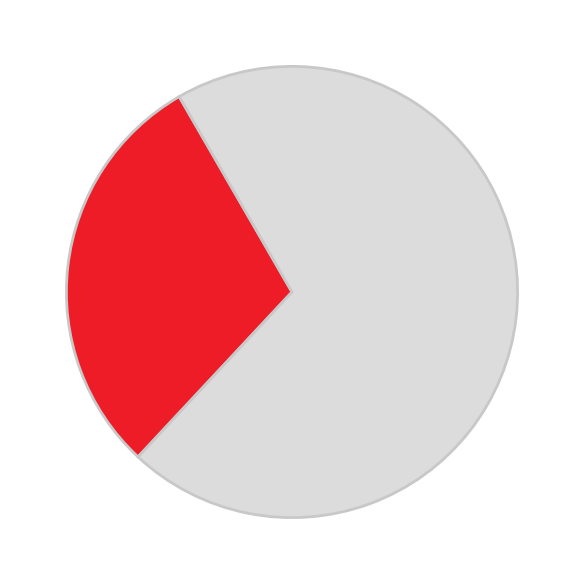

Sí (1): 93 (29.71%)
No (2): 220 (70.29%)


In [127]:
from matplotlib.patches import Wedge
import matplotlib.pyplot as plt
import numpy as np

# Colores sólidos
rojo_davivienda = (237/255, 28/255, 39/255)
gris_claro = (220/255, 220/255, 220/255)
borde_gris_claro = (200/255, 200/255, 200/255)  # Gris claro

plt.rcParams['font.family'] = 'Encode Sans, sans-serif'
plt.figure(figsize=(8,6))

# Filtra dist_p1 para excluir NaN y ordena por el valor de la calificación (1 primero, 2 después)
dist_p1_no_nan = dist_p1[dist_p1.index.notna()].sort_index()

# Etiquetas para la leyenda (ajusta según tus valores)
labels_leyenda = ['Sí (1)', 'No (2)']

# Pie chart sin etiquetas internas ni leyenda, borde gris claro y delgado
wedges, _ = plt.pie(
    dist_p1_no_nan,
    labels=None,
    autopct=None,
    startangle=120,
    colors=[rojo_davivienda, gris_claro],
    wedgeprops={'edgecolor': borde_gris_claro, 'linewidth': 2}
)

plt.gca().set_facecolor('white')
plt.gca().set_aspect('equal')
plt.box(False)

# Agregar leyenda
# plt.legend(wedges, labels_leyenda, loc='upper right', frameon=False, fontsize=12, title='¿Resolví tu inquietud?')

plt.tight_layout()
plt.show()

# Imprimir cantidades y porcentajes fuera del gráfico
total = dist_p1_no_nan.sum()
for label, value in zip(labels_leyenda, dist_p1_no_nan):
    porcentaje = value / total * 100 if total else 0
    print(f"{label}: {int(value)} ({porcentaje:.2f}%)")

### 3.2 Usuarios

In [128]:
# Leer el archivo CSV de usuarios
usuarios_path = '../USUARIOS/Usuarios Regionales - Antioquia.csv'
usuarios_df = pd.read_csv(usuarios_path, encoding='utf-8')
usuarios_df.columns = [col.strip().lower() for col in usuarios_df.columns]  # Normaliza nombres de columnas
df_merged_usuarios = pd.merge(df_merged_final, usuarios_df, left_on='correo', right_on='correo electrónico', how='left')

In [129]:
# Comparativo: usuarios habilitados vs usuarios que usan la herramienta
usuarios_habilitados = usuarios_df['correo electrónico'].nunique()
usuarios_que_usan = df_merged_final['correo'].nunique()
porcentaje_uso = usuarios_que_usan / usuarios_habilitados * 100 if usuarios_habilitados else 0

print(f"Usuarios habilitados: {usuarios_habilitados}")
print(f"Usuarios que usan la herramienta: {usuarios_que_usan}")
print(f"Porcentaje de usuarios que usan la herramienta: {porcentaje_uso:.2f}%")

Usuarios habilitados: 673
Usuarios que usan la herramienta: 392
Porcentaje de usuarios que usan la herramienta: 58.25%


findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Fon

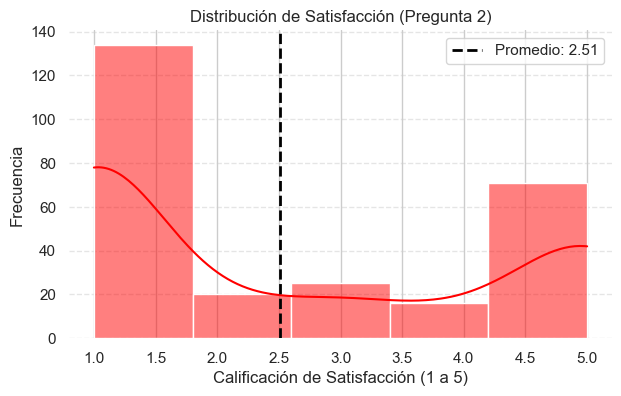

In [130]:
# --- Gráfica de distribución para la segunda métrica ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.histplot(p2_valid, bins=5, kde=True, color='red', edgecolor=None)
plt.title('Distribución de Satisfacción (Pregunta 2)')
plt.xlabel('Calificación de Satisfacción (1 a 5)')
plt.ylabel('Frecuencia')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Mostrar línea de promedio
if not p2_valid.empty:
    plt.axvline(p2_valid.mean(), color='black', linestyle='--', linewidth=2, label=f'Promedio: {p2_valid.mean():.2f}')
    plt.legend()

plt.show()

In [131]:
# Eliminar usuarios no regionales de consultas_conecta_1 antes de cualquier cálculo
usuarios_no_regionales = [
    'djcachope@davivienda.com',
    'luza.agudelo@davivienda.com',
    'mcalvarez@davivienda.com',
    'danirios@davivienda.com',
    'nsalas@davivienda.com',
    'imancini@davivienda.com'
]

# # --- Cálculo de grupos de usuarios según tu lógica ---

# 1. Usuarios totales (del archivo de usuarios regionales)
usuarios_totales = set(usuarios_df['correo electrónico'].dropna().str.lower().str.strip())

# 2. Usuarios conecta 1.0: están en consultas_conecta_1 pero NO en df_merged_final
correos_conecta_1 = set(consultas_conecta_1['correo'].dropna().str.lower().str.strip())
correos_merged_final = set(df_merged_final['correo'].dropna().str.lower().str.strip())

usuarios_conecta_1 = correos_conecta_1 - correos_merged_final

# 3. Usuarios conecta 2.0: están en df_merged_final pero NO en usuarios conecta 1.0
usuarios_conecta_2 = correos_merged_final - usuarios_conecta_1

# 4. Compartidos: usuarios que están en ambos (conecta 1.0 y df_merged_final)
usuarios_compartidos = correos_conecta_1 & correos_merged_final

total_usuarios = len(usuarios_totales)
porc_conecta_1 = len(usuarios_conecta_1) / total_usuarios * 100 if total_usuarios else 0
porc_conecta_2 = len(usuarios_conecta_2) / total_usuarios * 100 if total_usuarios else 0
porc_compartidos = len(usuarios_compartidos) / total_usuarios * 100 if total_usuarios else 0

print(f"Usuarios totales (archivo regionales): {total_usuarios}")

Usuarios totales (archivo regionales): 673


In [132]:
# --- Grupos excluyentes de usuarios ---
correos_conecta_1 = set(consultas_conecta_1['correo'].dropna().str.lower().str.strip())

# 1. Usuarios solo conecta 1.0 (exclusivos)
solo_conecta_1 = correos_conecta_1 - correos_merged_final

# 2. Usuarios solo conecta 2.0 (exclusivos)
solo_conecta_2 = correos_merged_final - correos_conecta_1

# 3. Usuarios compartidos (en ambos)
compartidos = correos_conecta_1 & correos_merged_final

# 4. Usuarios regionales que no aparecen en ninguna plataforma
otros = usuarios_totales - (solo_conecta_1 | solo_conecta_2 | compartidos)

print(f"Solo conecta 1.0: {len(solo_conecta_1)} ({len(solo_conecta_1)/total_usuarios*100:.2f}%)")
print(f"Solo conecta 2.0: {len(solo_conecta_2)} ({len(solo_conecta_2)/total_usuarios*100:.2f}%)")
print(f"Compartidos: {len(compartidos)} ({len(compartidos)/total_usuarios*100:.2f}%)")
print(f"Otros (no usan ninguna): {len(otros)} ({len(otros)/total_usuarios*100:.2f}%)")
print(f"Suma total: {len(solo_conecta_1) + len(solo_conecta_2) + len(compartidos) + len(otros)}")

Solo conecta 1.0: 38 (5.65%)
Solo conecta 2.0: 201 (29.87%)
Compartidos: 191 (28.38%)
Otros (no usan ninguna): 249 (37.00%)
Suma total: 679


In [133]:
adopcion_conecta2 = len(solo_conecta_2) + len(compartidos)
porcentaje_adopcion = adopcion_conecta2 / total_usuarios * 100

print(f"Adopción Conecta 2.0: {adopcion_conecta2} usuarios ({porcentaje_adopcion:.2f}%)")

Adopción Conecta 2.0: 392 usuarios (58.25%)


In [134]:
# --- Análisis solo para usuarios que usan alguna herramienta ---

# Universo: usuarios que usan al menos una herramienta
usuarios_usan = solo_conecta_1 | solo_conecta_2 | compartidos
total_usan = len(usuarios_usan)

porc_solo_conecta_1 = len(solo_conecta_1) / total_usan * 100 if total_usan else 0
porc_solo_conecta_2 = len(solo_conecta_2) / total_usan * 100 if total_usan else 0
porc_compartidos = len(compartidos) / total_usan * 100 if total_usan else 0

print(f"Total usuarios que usan alguna herramienta: {total_usan}")
print(f"Solo conecta 1.0: {len(solo_conecta_1)} ({porc_solo_conecta_1:.2f}%)")
print(f"Solo conecta 2.0: {len(solo_conecta_2)} ({porc_solo_conecta_2:.2f}%)")
print(f"Compartidos: {len(compartidos)} ({porc_compartidos:.2f}%)")
print(f"Suma total: {len(solo_conecta_1) + len(solo_conecta_2) + len(compartidos)}")

Total usuarios que usan alguna herramienta: 430
Solo conecta 1.0: 38 (8.84%)
Solo conecta 2.0: 201 (46.74%)
Compartidos: 191 (44.42%)
Suma total: 430


In [135]:
# Usuarios que solo tienen una (1) conversación en Conecta 2.0
usuarios_1conv = (
    df_merged_final.groupby('correo')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .reset_index()
)
usuarios_1conv = usuarios_1conv[usuarios_1conv['fk_tbl_conversaciones_conecta2'] == 1]['correo']
print(f"Usuarios con solo una conversación en Conecta 2.0: {len(usuarios_1conv)}")
print(usuarios_1conv.tolist())

Usuarios con solo una conversación en Conecta 2.0: 91
['acmazo@davivienda.com', 'ahernandez@davivienda.com', 'alevelez@davivienda.com', 'alexandra.rojas@davivienda.com', 'ambarrantes@davivienda.com', 'amcanola@davivienda.com', 'amescobar@davivienda.com', 'amramirezr@davivienda.com', 'andres.ramirez@davivienda.com', 'andres.velez@davivienda.com', 'asancheza@davivienda.com', 'avgonzal@davivienda.com', 'carlsern@davivienda.com', 'carolina.giraldo@davivienda.com', 'cgomeza@davivienda.com', 'crmunoz@davivienda.com', 'damunera@davivienda.com', 'danausug@davivienda.com', 'daniela.calderon@davivienda.com', 'dcardona@davivienda.com', 'diego.bedoya@davivienda.com', 'dyaristi@davivienda.com', 'erica.lujan@davivienda.com', 'estefania.mejia@davivienda.com', 'esvilleg@davivienda.com', 'evalencia@davivienda.com', 'fabautis@davivienda.com', 'fadlopez@davivienda.com', 'fegomez@davivienda.com', 'gdgalleg@davivienda.com', 'glondono@davivienda.com', 'jaguilar@davivienda.com', 'jagutier@davivienda.com', 'j

In [136]:
# ¿Estos usuarios usan Conecta 1.0 de manera más frecuente?
consultas_1_por_usuario = (
    consultas_conecta_1[consultas_conecta_1['correo'].isin(usuarios_1conv)]
    .groupby('correo')
    .size()
    .reset_index(name='consultas_conecta_1')
)
print(consultas_1_por_usuario)
print(consultas_1_por_usuario.describe())

                                      correo  consultas_conecta_1
0                      acmazo@davivienda.com                    1
1                    amcanola@davivienda.com                    8
2                andres.velez@davivienda.com                    2
3                    carlsern@davivienda.com                    6
4                     crmunoz@davivienda.com                    3
5                    damunera@davivienda.com                    2
6            daniela.calderon@davivienda.com                    8
7                diego.bedoya@davivienda.com                   22
8                 erica.lujan@davivienda.com                   10
9                    jasescob@davivienda.com                   14
10                    jcueroa@davivienda.com                   11
11                   jfjimesc@davivienda.com                   20
12  julian.rodriguezvelasquez@davivienda.com                    9
13                lizeth.usma@davivienda.com                    9
14        

In [137]:
# ¿Las interacciones en Conecta 1.0 fueron después de usar Conecta 2.0?
df_merged_final['fecha_hora_inicio'] = pd.to_datetime(df_merged_final['fecha_hora_inicio'], errors='coerce')
consultas_conecta_1['Fecha'] = pd.to_datetime(consultas_conecta_1['Fecha'], errors='coerce')

usuarios_1conv_fechas = df_merged_final[df_merged_final['correo'].isin(usuarios_1conv)].groupby('correo')['fecha_hora_inicio'].max()
consultas_1_fechas = consultas_conecta_1[consultas_conecta_1['correo'].isin(usuarios_1conv)].groupby('correo')['Fecha'].min()

comparativo_fechas = pd.DataFrame({
    'ultima_conecta2': usuarios_1conv_fechas,
    'primera_conecta1': consultas_1_fechas
})
comparativo_fechas['conecta1_despues'] = comparativo_fechas['primera_conecta1'] > comparativo_fechas['ultima_conecta2']
print(comparativo_fechas)
print(comparativo_fechas['conecta1_despues'].value_counts())

                                   ultima_conecta2    primera_conecta1  \
correo                                                                   
acmazo@davivienda.com          2025-08-26 15:04:52 2025-08-28 08:15:40   
ahernandez@davivienda.com      2025-08-27 15:08:06                 NaT   
alevelez@davivienda.com        2025-08-26 09:32:38                 NaT   
alexandra.rojas@davivienda.com 2025-08-28 08:32:59                 NaT   
ambarrantes@davivienda.com     2025-08-26 12:22:54                 NaT   
...                                            ...                 ...   
wmaya@davivienda.com           2025-08-29 12:52:19                 NaT   
yahincap@davivienda.com        2025-08-28 10:43:28                 NaT   
yilmer.arias@davivienda.com    2025-08-29 15:33:11 2025-08-26 09:50:56   
yurledy.tapias@davivienda.com  2025-08-26 15:04:12                 NaT   
yury.caro@davivienda.com       2025-08-27 08:38:14 2025-08-27 08:39:01   

                                conec

In [138]:
# Usuarios que solo usan Conecta 1.0
correos_conecta_1 = set(consultas_conecta_1['correo'].dropna().str.lower().str.strip())
correos_conecta_2 = set(df_merged_final['correo'].dropna().str.lower().str.strip())
solo_conecta_1 = correos_conecta_1 - correos_conecta_2
print(f"Usuarios que solo usan Conecta 1.0: {len(solo_conecta_1)}")
print(list(solo_conecta_1))

Usuarios que solo usan Conecta 1.0: 38
['yaperez@davivienda.com', 'jpcruzg@davivienda.com', 'camilo.betancur@davivienda.com', 'wahenao@davivienda.com', 'dagudelo@davivienda.com', 'steven.ramirez@davivienda.com', 'lvmejia@davivienda.com', 'chardila@davivienda.com', 'leflorez@davivienda.com', 'ldcarden@davivienda.com', 'margarci@davivienda.com', 'ivan.ramirez@davivienda.com', 'mcalvarez@davivienda.com', 'imancini@davivienda.com', 'luza.agudelo@davivienda.com', 'ediermont@davivienda.com', 'mevanega@davivienda.com', 'amagugom@davivienda.com', 'danirios@davivienda.com', 'leidy.gutierrez@davivienda.com', 'nsalas@davivienda.com', 'carvaneg@davivienda.com', 'jarboled@davivienda.com', 'admalvar@davivienda.com', 'bearangop@davivienda.com', 'tvvaldes@davivienda.com', 'diana.alvarez@davivienda.com', 'djcachope@davivienda.com', 'christian.guillermo@davivienda.com', 'yamesa@davivienda.com', 'angy.isaza@davivienda.com', 'jblandon@davivienda.com', 'jamorcor@davivienda.com', 'samuel.gonzalezgonzalez@da

In [139]:
import pandas as pd

# Ejemplo: supón que tienes varios DataFrames con los resultados de tus celdas
df_usuarios_1conv = pd.DataFrame({'correo': usuarios_1conv})
df_consultas_1_por_usuario = consultas_1_por_usuario
df_comparativo_fechas = comparativo_fechas
df_solo_conecta_1 = pd.DataFrame({'correo': list(solo_conecta_1)})

with pd.ExcelWriter('resultados_analisis.xlsx') as writer:
    df_usuarios_1conv.to_excel(writer, sheet_name='Usuarios_1_Conv', index=False)
    df_consultas_1_por_usuario.to_excel(writer, sheet_name='Consultas_Conecta1', index=False)
    df_comparativo_fechas.to_excel(writer, sheet_name='Comparativo_Fechas', index=True)
    df_solo_conecta_1.to_excel(writer, sheet_name='Solo_Conecta1', index=False)

In [140]:
# 1. Usuarios que usaron ambas herramientas
usuarios_conecta2 = set(df_merged_final['correo'].dropna().str.lower().str.strip())
usuarios_conecta1 = set(consultas_conecta_1['correo'].dropna().str.lower().str.strip())
usuarios_ambos = usuarios_conecta2 & usuarios_conecta1

# 2. Para cada usuario que usó ambas, comparar fechas de última interacción
adoptaron = []
se_fueron = []

for correo in usuarios_ambos:
    fecha_ultima_conecta2 = df_merged_final[df_merged_final['correo'].str.lower().str.strip() == correo]['fecha_hora_inicio'].max()
    fecha_ultima_conecta1 = consultas_conecta_1[consultas_conecta_1['correo'].str.lower().str.strip() == correo]['Fecha'].max()
    fecha_primera_conecta1_post_conecta2 = consultas_conecta_1[
        (consultas_conecta_1['correo'].str.lower().str.strip() == correo) &
        (consultas_conecta_1['Fecha'] > fecha_ultima_conecta2)
    ]['Fecha'].min()
    if pd.isna(fecha_primera_conecta1_post_conecta2):
        adoptaron.append(correo)
    else:
        se_fueron.append(correo)

print(f"Usuarios que adoptaron Conecta 2.0 y no volvieron a Conecta 1.0: {len(adoptaron)}")
print(adoptaron)
print(f"Usuarios que se fueron (volvieron a Conecta 1.0 tras usar Conecta 2.0): {len(se_fueron)}")
print(se_fueron)

# 3. Usuarios fieles a Conecta 1.0 (nunca usaron Conecta 2.0)
solo_conecta1 = usuarios_conecta1 - usuarios_conecta2
print(f"Usuarios fieles a Conecta 1.0: {len(solo_conecta1)}")
print(list(solo_conecta1))

Usuarios que adoptaron Conecta 2.0 y no volvieron a Conecta 1.0: 112
['yilmer.arias@davivienda.com', 'alramire@davivienda.com', 'lpalomeq@davivienda.com', 'lmalvare@davivienda.com', 'alahenao@davivienda.com', 'pbastida@davivienda.com', 'isarango@davivienda.com', 'marfranc@davivienda.com', 'mjmarque@davivienda.com', 'eucarist@davivienda.com', 'joaarroy@davivienda.com', 'lmnaranj@davivienda.com', 'pechavar@davivienda.com', 'lina.restrepo@davivienda.com', 'davila@davivienda.com', 'ccardona@davivienda.com', 'danna.vidal@davivienda.com', 'camilo.ramirez@davivienda.com', 'wiagonza@davivienda.com', 'jomunoz@davivienda.com', 'carolina.rendon@davivienda.com', 'maujruiz@davivienda.com', 'lchavera@davivienda.com', 'algudelo@davivienda.com', 'jfvalenciad@davivienda.com', 'jucasala@davivienda.com', 'seboteroc@davivienda.com', 'enriquea@davivienda.com', 'miguel.chalarca@davivienda.com', 'dairo.ospina@davivienda.com', 'debedoya@davivienda.com', 'durbi.piedrahita@davivienda.com', 'jarestrepos@davivien

In [141]:
import pandas as pd

# Crear DataFrames para cada grupo
df_adoptaron = pd.DataFrame({'correo': adoptaron})
df_se_fueron = pd.DataFrame({'correo': se_fueron})
df_solo_conecta1 = pd.DataFrame({'correo': list(solo_conecta1)})

# Guardar en un archivo Excel, cada grupo en una hoja diferente
with pd.ExcelWriter('usuarios_adopcion_conecta.xlsx') as writer:
    df_adoptaron.to_excel(writer, sheet_name='Adoptaron_Conecta2', index=False)
    df_se_fueron.to_excel(writer, sheet_name='Se_Fueron', index=False)
    df_solo_conecta1.to_excel(writer, sheet_name='Fieles_Conecta1', index=False)

### 3.3 Tiempo Conversación

In [142]:
# Estadísticas de mensajes por conversación
mensajes_por_conversacion = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2').size()

print("\n===== Estadísticas de mensajes por conversación =====")
print(f"Total de conversaciones: {mensajes_por_conversacion.shape[0]}")
print(f"Promedio de mensajes por conversación: {mensajes_por_conversacion.mean():.2f}")
print(f"Mediana de mensajes por conversación: {mensajes_por_conversacion.median():.2f}")
print(f"Desviación estándar: {mensajes_por_conversacion.std():.2f}")
print(f"Máximo de mensajes en una conversación: {mensajes_por_conversacion.max()}")
print(f"Mínimo de mensajes en una conversación: {mensajes_por_conversacion.min()}")
print(f"Percentil 25: {mensajes_por_conversacion.quantile(0.25):.2f}")
print(f"Percentil 75: {mensajes_por_conversacion.quantile(0.75):.2f}")


===== Estadísticas de mensajes por conversación =====
Total de conversaciones: 1925
Promedio de mensajes por conversación: 1.72
Mediana de mensajes por conversación: 1.00
Desviación estándar: 1.01
Máximo de mensajes en una conversación: 8
Mínimo de mensajes en una conversación: 1
Percentil 25: 1.00
Percentil 75: 2.00


In [143]:
df_merged_usuarios['fecha_hora_inicio'] = pd.to_datetime(df_merged_usuarios['fecha_hora_inicio'])
df_merged_usuarios['fecha_hora_fin'] = pd.to_datetime(df_merged_usuarios['fecha_hora_fin'])

In [144]:
# Calcular duración de cada conversación (en minutos)
df_merged_usuarios['duracion_min'] = (
    df_merged_usuarios['fecha_hora_fin'] - df_merged_usuarios['fecha_hora_inicio']
).dt.total_seconds() / 60

# Agrupar por conversación y calcular estadísticas
stats_conversacion = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2').agg(
    mensajes=('fk_tbl_conversaciones_conecta2', 'count'),
    duracion_min=('duracion_min', 'max')  # max porque todas las filas de una conversación tienen la misma duración
)

# Estadísticas descriptivas de duración
print("\n===== Estadísticas de duración por conversación =====")
print(f"Promedio de duración (min): {stats_conversacion['duracion_min'].mean():.2f}")
print(f"Mediana de duración (min): {stats_conversacion['duracion_min'].median():.2f}")
print(f"Desviación estándar: {stats_conversacion['duracion_min'].std():.2f}")
print(f"Duración mínima: {stats_conversacion['duracion_min'].min():.2f}")
print(f"Duración máxima: {stats_conversacion['duracion_min'].max():.2f}")

# Relación entre duración y cantidad de mensajes
print("\n===== Relación duración vs cantidad de mensajes =====")
print(stats_conversacion[['mensajes', 'duracion_min']].corr())


===== Estadísticas de duración por conversación =====
Promedio de duración (min): 22.29
Mediana de duración (min): 6.43
Desviación estándar: 58.23
Duración mínima: 0.13
Duración máxima: 1170.12

===== Relación duración vs cantidad de mensajes =====
              mensajes  duracion_min
mensajes      1.000000     -0.004443
duracion_min -0.004443      1.000000


In [145]:
# Filtrar la conversación más larga (mayor duración en minutos)
id_conversacion_larga = stats_conversacion['duracion_min'].idxmax()
conversacion_larga = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'] == id_conversacion_larga]

print(f"ID de la conversación más larga: {id_conversacion_larga}")
print(f"Duración (min): {stats_conversacion.loc[id_conversacion_larga, 'duracion_min']:.2f}")
print(f"Mensajes enviados: {stats_conversacion.loc[id_conversacion_larga, 'mensajes']}")

df_merged_usuarios[df_merged_usuarios.fk_tbl_conversaciones_conecta2 == id_conversacion_larga]

ID de la conversación más larga: 1748
Duración (min): 1170.12
Mensajes enviados: 2


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv,calificacion_pregunta_1,calificacion_pregunta_2,correo electrónico,nombre posición,nombre,duracion_min
1758,3480,1748,credi conexion,¿Podrías contarme un poco más sobre qué te gus...,<NA>,<NA>,20250828,1748.0,2025-08-27 15:16:11,2025-08-28 10:46:18,maloryn.garcia@davivienda.com,NaN,NaN,20250828,NaN,NaN,maloryn.garcia@davivienda.com,INFORMADOR (A) T.F 0393,Maloryn Andrea Garcia Saldarriaga,1170.116667
1759,3481,1748,radicar una solicitud en credi conexion \nAl r...,"Para radicar una solicitud en Credi Conexión, ...",None,None,20250828,1748.0,2025-08-27 15:16:11,2025-08-28 10:46:18,maloryn.garcia@davivienda.com,NaN,NaN,20250828,NaN,NaN,maloryn.garcia@davivienda.com,INFORMADOR (A) T.F 0393,Maloryn Andrea Garcia Saldarriaga,1170.116667


### 3.4 Motivo Experto

In [146]:
# Analizar la columna 'motivo_experto' a nivel conversacional
# filepath: c:\Users\gabrieva\Visual_Studio_Code_Files\[Conecta] Tablero BI\NOTEBOOKS\kpis_metricas.ipynb

# Agrupa por conversación y toma el primer motivo_experto de cada conversación
motivos_por_conversacion = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto'].first()

# Conteo de motivos únicos
conteo_motivos = motivos_por_conversacion.value_counts(dropna=False)

print("===== Análisis de 'motivo_experto' por conversación =====")
print("Total de conversaciones analizadas:", len(motivos_por_conversacion))
print("\nDistribución de motivos:")
print(conteo_motivos)

# Porcentaje de cada motivo
porcentaje_motivos = conteo_motivos / len(motivos_por_conversacion) * 100
print("\nPorcentaje por motivo:")
print(porcentaje_motivos.round(2))

===== Análisis de 'motivo_experto' por conversación =====
Total de conversaciones analizadas: 1925

Distribución de motivos:
motivo_experto
None            1663
Usuario          193
IA                57
Usuario + IA      12
Name: count, dtype: int64

Porcentaje por motivo:
motivo_experto
None            86.39
Usuario         10.03
IA               2.96
Usuario + IA     0.62
Name: count, dtype: float64


===== Análisis de número de mensajes por motivo_experto =====
                count      mean  median       std  min  max
motivo_experto                                             
Usuario           193  2.435233     2.0  1.144371    1    8
IA                 57  3.614035     3.0  0.940258    2    6
Usuario + IA       12  3.500000     3.0  1.087115    2    6


<Figure size 1000x500 with 0 Axes>

findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Fon

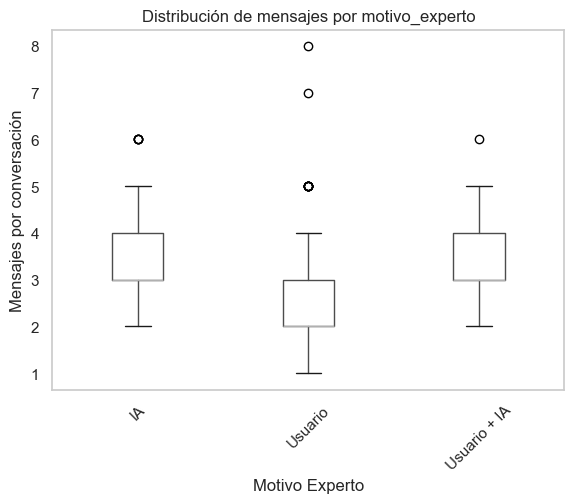

In [147]:
# Análisis del número de mensajes por conversación y su relación con 'motivo_experto'
# filepath: c:\Users\gabrieva\Visual_Studio_Code_Files\[Conecta] Tablero BI\NOTEBOOKS\kpis_metricas.ipynb

# Agrupa por conversación y obtiene el motivo y el número de mensajes
mensajes_motivo = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2').agg(
    motivo_experto=('motivo_experto', 'first'),
    mensajes=('fk_tbl_conversaciones_conecta2', 'count')
)

# Estadísticas descriptivas por motivo
resumen_motivo = mensajes_motivo.groupby('motivo_experto')['mensajes'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).sort_values('count', ascending=False)

print("===== Análisis de número de mensajes por motivo_experto =====")
print(resumen_motivo)

# Si quieres ver la distribución de mensajes por motivo en forma de tabla:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
mensajes_motivo.boxplot(column='mensajes', by='motivo_experto', grid=False, rot=45)
plt.title('Distribución de mensajes por motivo_experto')
plt.suptitle('')
plt.xlabel('Motivo Experto')
plt.ylabel('Mensajes por conversación')
plt.show()

In [148]:
# 1. Normalizar la columna 'calificacion': solo conservar 'Mal', el resto asignar None
# Solución: verifica si x es NA antes de comparar
df_merged_usuarios['calificacion_filtrada'] = df_merged_usuarios['calificacion'].apply(
    lambda x: x if pd.notna(x) and x == 'Mal' else None
)

# 2. Agrupar por conversación y motivo_experto, contar calificaciones negativas
calif_motivo = (
    df_merged_usuarios
    .assign(motivo_experto_norm = df_merged_usuarios['motivo_experto'].fillna('Sin motivo'))
    .groupby(['fk_tbl_conversaciones_conecta2', 'motivo_experto_norm'])['calificacion_filtrada']
    .apply(lambda x: (x == 'Mal').sum())
    .reset_index(name='mal_count')
)

# 3. Resumir por motivo_experto
resumen_motivo_mal = calif_motivo.groupby('motivo_experto_norm')['mal_count'].agg(['sum', 'count']).sort_values('sum', ascending=False)
resumen_motivo_mal['porcentaje_conversaciones_con_mal'] = resumen_motivo_mal['sum'] / resumen_motivo_mal['count'] * 100

print("===== Relación entre calificación negativa ('Mal') y motivo_experto =====")
print(resumen_motivo_mal)

# 4. ¿Las conversaciones con 'Mal' tienen motivo_experto asignado?
mal_rows = df_merged_usuarios[df_merged_usuarios['calificacion_filtrada'] == 'Mal']
motivos_mal = mal_rows['motivo_experto'].fillna('Sin motivo').value_counts(dropna=False)
print("\nMotivo_experto en interacciones con calificación 'Mal':")
print(motivos_mal)

# 5. ¿Algún motivo_experto se asocia más a 'Mal'?
print("\nPorcentaje de conversaciones con 'Mal' por motivo_experto:")
print(resumen_motivo_mal[['porcentaje_conversaciones_con_mal']])

===== Relación entre calificación negativa ('Mal') y motivo_experto =====
                     sum  count  porcentaje_conversaciones_con_mal
motivo_experto_norm                                               
Usuario              142    193                          73.575130
Sin motivo           137   1663                           8.238124
Usuario + IA          13     12                         108.333333
IA                     7     57                          12.280702

Motivo_experto en interacciones con calificación 'Mal':
motivo_experto
Usuario         142
Sin motivo      137
Usuario + IA     13
IA                7
Name: count, dtype: int64

Porcentaje de conversaciones con 'Mal' por motivo_experto:
                     porcentaje_conversaciones_con_mal
motivo_experto_norm                                   
Usuario                                      73.575130
Sin motivo                                    8.238124
Usuario + IA                                108.333333
IA         

In [149]:
# Análisis de ruta de usuarios que asignaron calificación a la conversación

# 1. Conversaciones con al menos una calificación en p1 o p2
convs_con_calif_ids = convs_con_calif.index.tolist()
df_calif_convs = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'].isin(convs_con_calif_ids)]

# 2. Ruta: ¿Estas conversaciones tienen motivo_experto o es None?
ruta_motivo = (
    df_calif_convs
    .groupby('fk_tbl_conversaciones_conecta2')['motivo_experto']
    .first()
    .fillna('Sin motivo')
    .reset_index()
)

# 3. Estadísticas por grupo (con motivo_experto vs Sin motivo)
grupo_con_motivo = ruta_motivo[ruta_motivo['motivo_experto'] != 'Sin motivo']
grupo_sin_motivo = ruta_motivo[ruta_motivo['motivo_experto'] == 'Sin motivo']

print(f"Total conversaciones calificadas: {len(ruta_motivo)}")
print(f"Con motivo_experto: {len(grupo_con_motivo)} ({len(grupo_con_motivo)/len(ruta_motivo)*100:.2f}%)")
print(f"Sin motivo_experto: {len(grupo_sin_motivo)} ({len(grupo_sin_motivo)/len(ruta_motivo)*100:.2f}%)")

# 4. ¿Cuál motivo_experto tienen las que sí?
motivo_counts = grupo_con_motivo['motivo_experto'].value_counts()
print("\nMotivo_experto en conversaciones calificadas:")
print(motivo_counts)

# 5. Para las que NO tienen motivo_experto, ¿dieron alguna calificación 'Mal'?
sin_motivo_ids = grupo_sin_motivo['fk_tbl_conversaciones_conecta2'].tolist()
sin_motivo_rows = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'].isin(sin_motivo_ids)]
sin_motivo_mal = sin_motivo_rows.groupby('fk_tbl_conversaciones_conecta2')['calificacion_filtrada'].apply(lambda x: (x == 'Mal').any())
num_sin_motivo_mal = sin_motivo_mal.sum()
print(f"\nConversaciones SIN motivo_experto con al menos una calificación 'Mal': {num_sin_motivo_mal} ({num_sin_motivo_mal/len(grupo_sin_motivo)*100:.2f}%)")

# 6. Estadísticas adicionales
def stats_grupo(df, nombre):
    mensajes = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'].isin(df['fk_tbl_conversaciones_conecta2'])]
    n_convs = df.shape[0]
    n_usuarios = mensajes['correo'].nunique()
    prom_mensajes = mensajes.groupby('fk_tbl_conversaciones_conecta2').size().mean()
    print(f"\nGrupo: {nombre}")
    print(f"Conversaciones: {n_convs}")
    print(f"Usuarios únicos: {n_usuarios}")
    print(f"Promedio mensajes por conversación: {prom_mensajes:.2f}")
    print(f"Promedio duración (min): {mensajes.groupby('fk_tbl_conversaciones_conecta2')['duracion_min'].max().mean():.2f}")

stats_grupo(grupo_con_motivo, "Con motivo_experto")
stats_grupo(grupo_sin_motivo, "Sin motivo_experto")

# Puedes agregar más estadísticas según lo que necesites (mediana, desviación estándar, etc.)

Total conversaciones calificadas: 376
Con motivo_experto: 130 (34.57%)
Sin motivo_experto: 246 (65.43%)

Motivo_experto en conversaciones calificadas:
motivo_experto
Usuario         100
IA               25
Usuario + IA      5
Name: count, dtype: int64

Conversaciones SIN motivo_experto con al menos una calificación 'Mal': 37 (15.04%)

Grupo: Con motivo_experto
Conversaciones: 130
Usuarios únicos: 75
Promedio mensajes por conversación: 2.68
Promedio duración (min): 17.77

Grupo: Sin motivo_experto
Conversaciones: 246
Usuarios únicos: 131
Promedio mensajes por conversación: 1.66
Promedio duración (min): 20.02


In [150]:
# 1. Identificar conversaciones con motivo 'Usuario' pero sin calificación negativa
usuario_convs = df_merged_usuarios[(df_merged_usuarios['motivo_experto'] == 'Usuario') | (df_merged_usuarios['motivo_experto'] == 'Usuario + IA')]
usuario_convs_grouped = usuario_convs.groupby('fk_tbl_conversaciones_conecta2')['calificacion_filtrada'].apply(lambda x: (x == 'Mal').any()).reset_index()
sin_mal_usuario = usuario_convs_grouped[usuario_convs_grouped['calificacion_filtrada'] == False]['fk_tbl_conversaciones_conecta2']
convs_detalle = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'].isin(sin_mal_usuario)]

# 2. Buscar la palabra 'Mal' en los valores de las columnas relevantes
# Si 'Mal' aparece en alguna columna tipo texto (ejemplo: 'pregunta'), asignar 'Mal' a 'calificacion_filtrada'
mask_mal_pregunta = convs_detalle['pregunta'].astype(str).str.contains(r'\bMal\b', case=False, na=False)
convs_detalle.loc[mask_mal_pregunta, 'calificacion_filtrada'] = 'Mal'

# 3. Actualizar el DataFrame original con los nuevos valores
df_merged_usuarios.loc[convs_detalle.index, 'calificacion_filtrada'] = convs_detalle['calificacion_filtrada']

# 4. Repetir el análisis
# Agrupa por conversación y motivo, y verifica si hay al menos un 'Mal'
calif_motivo_bin = (
    df_merged_usuarios
    .assign(motivo_experto_norm = df_merged_usuarios['motivo_experto'].fillna('Sin motivo'))
    .groupby(['fk_tbl_conversaciones_conecta2', 'motivo_experto_norm'])['calificacion_filtrada']
    .apply(lambda x: (x == 'Mal').any())
    .reset_index(name='tiene_mal')
)

# Resumir por motivo_experto
resumen_motivo_mal_bin = calif_motivo_bin.groupby('motivo_experto_norm')['tiene_mal'].agg(['sum', 'count'])
resumen_motivo_mal_bin['porcentaje_conversaciones_con_mal'] = resumen_motivo_mal_bin['sum'] / resumen_motivo_mal_bin['count'] * 100

print("===== Porcentaje de conversaciones con al menos un 'Mal' por motivo_experto =====")
print(resumen_motivo_mal_bin)

===== Porcentaje de conversaciones con al menos un 'Mal' por motivo_experto =====
                     sum  count  porcentaje_conversaciones_con_mal
motivo_experto_norm                                               
IA                     7     57                          12.280702
Sin motivo           130   1663                           7.817198
Usuario              192    193                          99.481865
Usuario + IA          12     12                         100.000000


In [151]:
# Análisis: ¿Cuántas calificaciones 'Mal' hay por motivo_experto?

# 1. Agrupa por conversación y motivo_experto, cuenta calificaciones 'Mal' por conversación
mal_por_conversacion = (
    df_merged_usuarios
    .assign(motivo_experto_norm = df_merged_usuarios['motivo_experto'].fillna('Sin motivo'))
    .groupby(['fk_tbl_conversaciones_conecta2', 'motivo_experto_norm'])['calificacion_filtrada']
    .apply(lambda x: (x == 'Mal').sum())
    .reset_index(name='mal_count')
)

# 2. Resumir por motivo_experto: suma total de 'Mal' y número de conversaciones
resumen_mal_motivo = mal_por_conversacion.groupby('motivo_experto_norm')['mal_count'].agg(['sum', 'count'])
print("===== Calificaciones 'Mal' por motivo_experto =====")
print(resumen_mal_motivo)

# 3. Conversaciones sin motivo_experto explícito ('Sin motivo') con al menos una calificación 'Mal'
sin_motivo_mal = mal_por_conversacion[
    (mal_por_conversacion['motivo_experto_norm'] == 'Sin motivo') & (mal_por_conversacion['mal_count'] > 0)
]
print(f"\nConversaciones 'Sin motivo' con al menos una calificación 'Mal': {sin_motivo_mal.shape[0]}")
print(sin_motivo_mal[['fk_tbl_conversaciones_conecta2', 'mal_count']].head())

===== Calificaciones 'Mal' por motivo_experto =====
                     sum  count
motivo_experto_norm            
IA                     7     57
Sin motivo           137   1663
Usuario              233    193
Usuario + IA          14     12

Conversaciones 'Sin motivo' con al menos una calificación 'Mal': 130
    fk_tbl_conversaciones_conecta2  mal_count
9                              277          1
70                             366          1
76                             374          1
88                             393          1
96                             407          1


In [152]:
# Distribución de calificaciones 'Mal' promedio por motivo_experto

# Calcula el promedio de calificaciones 'Mal' por conversación para cada motivo
promedio_mal_por_motivo = mal_por_conversacion.groupby('motivo_experto_norm')['mal_count'].mean().reset_index()
promedio_mal_por_motivo = promedio_mal_por_motivo.rename(columns={'mal_count': 'promedio_mal_por_conversacion'})

print("===== Promedio de calificaciones 'Mal' por conversación para cada motivo_experto =====")
print(promedio_mal_por_motivo)

===== Promedio de calificaciones 'Mal' por conversación para cada motivo_experto =====
  motivo_experto_norm  promedio_mal_por_conversacion
0                  IA                       0.122807
1          Sin motivo                       0.082381
2             Usuario                       1.207254
3        Usuario + IA                       1.166667


#### 3.4.0 Calificaciones

In [153]:
resumen = (
    df_merged_usuarios
    .assign(motivo_experto_norm = df_merged_usuarios['motivo_experto'].fillna('Sin motivo'))
    .groupby(['motivo_experto_norm', 'fk_tbl_conversaciones_conecta2'])
    .agg(
        p2_calificada = ('calificacion_pregunta_2', lambda x: x.notna().any())
    )
    .reset_index()
    .groupby('motivo_experto_norm')
    .agg(
        calif_1_count = ('fk_tbl_conversaciones_conecta2', lambda x: (df_merged_usuarios.loc[x.index, 'calificacion_pregunta_1'] == 1).sum()),
        calif_2_count = ('fk_tbl_conversaciones_conecta2', lambda x: (df_merged_usuarios.loc[x.index, 'calificacion_pregunta_1'] == 2).sum()),
        promedio_p2 = ('fk_tbl_conversaciones_conecta2', lambda x: df_merged_usuarios.loc[x.index, 'calificacion_pregunta_2'].mean()),
        conversaciones_unicas = ('fk_tbl_conversaciones_conecta2', 'nunique'),
        p2_count = ('p2_calificada', 'sum')
    )
    .reset_index()
)

print(resumen)

  motivo_experto_norm  calif_1_count  calif_2_count  promedio_p2  \
0                  IA              3              8     2.846154   
1          Sin motivo             83            265     2.429003   
2             Usuario              9             13     2.576923   
3        Usuario + IA              0              6     1.000000   

   conversaciones_unicas  p2_count  
0                     57        20  
1                   1663       163  
2                    193        79  
3                     12         4  


#### 3.4.1 Genesys

In [154]:
# 1. Filtrar df_merged_usuarios para aquellos que tengan algún valor en 'motivo_experto' (excluye NaN y None)

# df_merged_usuarios = 

df_filtrado = df_merged_usuarios[df_merged_usuarios['motivo_experto'].notna() & (df_merged_usuarios['motivo_experto'] != '')]

# 2. Agrupar por conversación, correo y motivo_experto
df_agrupado = (
    df_filtrado
    .groupby(['fk_tbl_conversaciones_conecta2', 'correo', 'motivo_experto'], as_index=False)
    .agg(
        interacciones=('fk_tbl_conversaciones_conecta2', 'count'),
        calificacion_pregunta_1=('calificacion_pregunta_1', 'max'),
        calificacion_pregunta_2=('calificacion_pregunta_2', 'max')
    )
)

In [155]:
df_agrupado.head(2)

,fk_tbl_conversaciones_conecta2,correo,motivo_experto,interacciones,calificacion_pregunta_1,calificacion_pregunta_2
0,266,anortiac@davivienda.com,IA,3,NaN,NaN
1,273,camila.santamaria@davivienda.com,IA,4,NaN,NaN


In [156]:
chat_conecta2.head(2)

,NRO_IDENTIFICACION_CONVERSACION,NRO_IDENTIFICACION_COMUNICACION_GENESYS,NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS,NRO_IDENTIFICACION_COLAS_USUARIO,NRO_IDENTIFICACION_FLUJO_INGRESO_INTERACCION,DIRECCION_INICIAL_INTERACCION,NRO_IDENTIFICACION_ROOM_COBROWSE,INTERACCION_ABANDONADA,HORA_INICIO_CONVERSACION,HORA_FIN_CONVERSACION,TIEMPO_INTERACCION_AGENTE,TIEMPO_RESPUESTA_AGENTE,COD_MOTIVO_LLAMADA_CLIENTE,CAMPO_INFORMACION_INTERACCION,ESTADO_INTERACCION,LENGUAJE_USADO,TIPO_MEDIO,NRO_IDENTIFICACION_ASESOR,NOMBRE_ASESOR,NRO_CLIENTE,COD_TIPO_DOCUMENTO_CLIENTE,NRO_IDENTIFICACION_CLIENTE,CANAL_ORIGEN,ZONA_ORIGEN,CATEGORIA_1,PRODUCTO_1,NRO_IP_USUARIO,CORREO_CLIENTE,AUTORIZACION_TRATAMIENTO_DATOS,TRANSCRIPCION_CLIENTE,TRANSCRIPCION_ASESOR,VALORACION_SENTIMIENTO_TENDENCIA,VALORACION_SENTIMIENTO,PERIODO
0,9FD77919-6A67-4D01-94AA-17D50BA49DBE,348533AC-2DB3-4251-9A60-C6582DB31883,79584877-8915-4FBD-B1CC-0F8279A76A6D,0C5A021E-D178-4184-AB93-61CD5FFBD1D3,4527520A-78CB-4F6F-82A5-65FADC7D58F6,INBOXXXXX,NaN,NaN,2025-08-31 15:52:39.738,2025-08-31 16:04:58.183,544.0,0.0,750C79E6-2CD8-40FD-9E04-5C7DE744C440,1095791149,TERMINATED,ES-US,MESSAGE,7FC3A4CD-C53A-4897-8520-6FF0D9AF905B,EM3-XXXXX,NaN,01,1095791149,APP,PUBLICA,NaN,NaN,FE710801-932D-47E7-B6D8-6ADA76C75E81,XXXXX@GMAIL.COM,SI,"VIVI BUENAS TARDES, BIENVENIDO A DAVIVIENDA . ...","VIVI BUENAS TARDES, BIENVENIDO A DAVIVIENDA . ...","-0,58273983","-0,0816361",2025-08-31
1,8F00CE7B-3133-4559-8F8E-FD7529007179,5A3DB8A2-562D-4C76-850C-9F2CBC215A53,34BD61C9-4A3F-4739-A207-A6A5C9E78B7D,0C5A021E-D178-4184-AB93-61CD5FFBD1D3,4527520A-78CB-4F6F-82A5-65FADC7D58F6,INBOXXXXX,NaN,NaN,2025-08-31 22:11:55.343,2025-08-31 22:21:31.904,201.0,0.0,1F7B2C1D-ED39-48CD-BD79-85CD332770BE,1235043902,TERMINATED,ES-US,MESSAGE,5371FD88-4407-4F7E-AC23-F3B4ED616BA1,EM3-XXXXX,NaN,01,1235043902,APP,PUBLICA,NaN,NaN,D9DFDFB9-572D-42D0-8FEE-E1C78EBC3692,XXXXX@GMAIL.COM,SI,USUARIO MI CUENTA DESPUES DE COLOCAR LA CLAVE ...,USUARIO USUARIO MI CUENTA DESPUES DE COLOCAR L...,"-0,03939188","-0,07878376",2025-08-31


In [157]:
# Asegura que ambas columnas sean string para evitar problemas de tipo
df_agrupado['fk_tbl_conversaciones_conecta2'] = df_agrupado['fk_tbl_conversaciones_conecta2'].astype(str)
chat_conecta2['NRO_IP_USUARIO'] = chat_conecta2['NRO_IP_USUARIO'].astype(str)

# Elimina duplicados en chat_conecta2 para asegurar un solo cruce por conversación
chat_conecta2_unico = chat_conecta2.drop_duplicates(subset=['NRO_IP_USUARIO'])

# Merge usando conversación como llave
df_merged_genesys = pd.merge(
    df_agrupado,
    chat_conecta2_unico,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='NRO_IP_USUARIO',
    how='left',
    suffixes=('_agrupado', '_genesys')
)

print(df_agrupado.shape)
print(df_merged_genesys.shape)
df_merged_genesys.head()

(262, 6)
(262, 40)


,fk_tbl_conversaciones_conecta2,correo,motivo_experto,interacciones,calificacion_pregunta_1,calificacion_pregunta_2,NRO_IDENTIFICACION_CONVERSACION,NRO_IDENTIFICACION_COMUNICACION_GENESYS,NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS,NRO_IDENTIFICACION_COLAS_USUARIO,NRO_IDENTIFICACION_FLUJO_INGRESO_INTERACCION,DIRECCION_INICIAL_INTERACCION,NRO_IDENTIFICACION_ROOM_COBROWSE,INTERACCION_ABANDONADA,HORA_INICIO_CONVERSACION,HORA_FIN_CONVERSACION,TIEMPO_INTERACCION_AGENTE,TIEMPO_RESPUESTA_AGENTE,COD_MOTIVO_LLAMADA_CLIENTE,CAMPO_INFORMACION_INTERACCION,ESTADO_INTERACCION,LENGUAJE_USADO,TIPO_MEDIO,NRO_IDENTIFICACION_ASESOR,NOMBRE_ASESOR,NRO_CLIENTE,COD_TIPO_DOCUMENTO_CLIENTE,NRO_IDENTIFICACION_CLIENTE,CANAL_ORIGEN,ZONA_ORIGEN,CATEGORIA_1,PRODUCTO_1,NRO_IP_USUARIO,CORREO_CLIENTE,AUTORIZACION_TRATAMIENTO_DATOS,TRANSCRIPCION_CLIENTE,TRANSCRIPCION_ASESOR,VALORACION_SENTIMIENTO_TENDENCIA,VALORACION_SENTIMIENTO,PERIODO
0,266,anortiac@davivienda.com,IA,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,273,camila.santamaria@davivienda.com,IA,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,303,nmospin@davivienda.com,IA,6,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,307,stepfcor@davivienda.com,Usuario,3,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,314,paula.arboleda@davivienda.com,Usuario,2,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
matches = df_merged_genesys[~df_merged_genesys['ESTADO_INTERACCION'].isna()]
num_matches = matches['fk_tbl_conversaciones_conecta2'].nunique()
total_convs = df_agrupado['fk_tbl_conversaciones_conecta2'].nunique()
print(f"Conversaciones con match: {num_matches} de {total_convs} ({num_matches/total_convs*100:.2f}%)")

# Solo cuenta como match si existe información de chat_conecta2 (por ejemplo, columna 'id' o similar)
matches = df_merged_genesys[~df_merged_genesys['ESTADO_INTERACCION'].isna()]
num_matches = matches['fk_tbl_conversaciones_conecta2'].nunique()

Conversaciones con match: 69 de 262 (26.34%)


In [159]:
# ...existing code...

matches = df_merged_genesys[~df_merged_genesys['ESTADO_INTERACCION'].isna()]
num_matches = matches['fk_tbl_conversaciones_conecta2'].nunique()
total_convs = df_agrupado['fk_tbl_conversaciones_conecta2'].nunique()
print(f"Conversaciones con match: {num_matches} de {total_convs} ({num_matches/total_convs*100:.2f}%)")

# Motivo_experto para conversaciones que hacen match
motivo_match = matches.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto'].first().value_counts(dropna=False)
motivo_match_pct = motivo_match / num_matches * 100 if num_matches else 0

print("\nMotivo_experto en conversaciones con match:")
for motivo, count in motivo_match.items():
    print(f"{motivo}: {count} ({motivo_match_pct[motivo]:.2f}%)")
# ...existing code...

Conversaciones con match: 69 de 262 (26.34%)

Motivo_experto en conversaciones con match:
Usuario: 62 (89.86%)
IA: 5 (7.25%)
Usuario + IA: 2 (2.90%)


In [160]:
# Haz una copia explícita antes de modificar la columna
matches = matches.copy()
matches['HORA_INICIO_CONVERSACION'] = pd.to_datetime(matches['HORA_INICIO_CONVERSACION'], errors='coerce')

# Agrupa por fecha y motivo_experto y cuenta el número de conversaciones
conteo_fecha_motivo = (
    matches.groupby([matches['HORA_INICIO_CONVERSACION'].dt.date, 'motivo_experto'])
    ['fk_tbl_conversaciones_conecta2']
    .nunique()
    .reset_index(name='num_conversaciones')
)

print("Conteo de conversaciones por fecha y motivo_experto (solo matches):")
print(conteo_fecha_motivo)

Conteo de conversaciones por fecha y motivo_experto (solo matches):
  HORA_INICIO_CONVERSACION motivo_experto  num_conversaciones
0               2025-08-27             IA                   4
1               2025-08-27        Usuario                  14
2               2025-08-27   Usuario + IA                   2
3               2025-08-28        Usuario                  23
4               2025-08-29             IA                   1
5               2025-08-29        Usuario                  19
6               2025-08-30        Usuario                   6


In [161]:
# ...existing code...

matches = df_merged_genesys[~df_merged_genesys['ESTADO_INTERACCION'].isna()]
num_matches = matches['fk_tbl_conversaciones_conecta2'].nunique()
total_convs = df_agrupado['fk_tbl_conversaciones_conecta2'].nunique()
print(f"Conversaciones con match: {num_matches} de {total_convs} ({num_matches/total_convs*100:.2f}%)")

# Motivo_experto para conversaciones que hacen match
motivo_match = matches.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto'].first().value_counts(dropna=False)
motivo_match_pct = motivo_match / num_matches * 100 if num_matches else 0

print("\nMotivo_experto en conversaciones con match:")
for motivo, count in motivo_match.items():
    print(f"{motivo}: {count} ({motivo_match_pct[motivo]:.2f}%)")
# ...existing code...

Conversaciones con match: 69 de 262 (26.34%)

Motivo_experto en conversaciones con match:
Usuario: 62 (89.86%)
IA: 5 (7.25%)
Usuario + IA: 2 (2.90%)


In [162]:
# Correos que NO hicieron match (Id Chat nulo)
correos_sin_match = df_merged_genesys[df_merged_genesys['ESTADO_INTERACCION'].isna()]['correo'].unique()
print(f"Correos sin match: {len(correos_sin_match)}")
print(correos_sin_match)

Correos sin match: 123
['anortiac@davivienda.com' 'camila.santamaria@davivienda.com'
 'nmospin@davivienda.com' 'stepfcor@davivienda.com'
 'paula.arboleda@davivienda.com' 'diana.estrada@davivienda.com'
 'laura.villegas@davivienda.com' 'debedoya@davivienda.com'
 'sxlopez@davivienda.com' 'enriquea@davivienda.com'
 'gabriel.gomez@davivienda.com' 'lialzate@davivienda.com'
 'lizeth.villegas@davivienda.com' 'davila@davivienda.com'
 'jtaborda@davivienda.com' 'decastil@davivienda.com'
 'lilopezm@davivienda.com' 'jessica.arevalo@davivienda.com'
 'jarestrepos@davivienda.com' 'yaagumej@davivienda.com'
 'elramire@davivienda.com' 'nathalia.ruiz@davivienda.com'
 'danna.vidal@davivienda.com' 'jorramir@davivienda.com'
 'alramire@davivienda.com' 'eddy.ospina@davivienda.com'
 'anamlope@davivienda.com' 'papermes@davivienda.com'
 'oalvarez@davivienda.com' 'emcardonap@davivienda.com'
 'luisa.suarez@davivienda.com' 'santiago.quiroz@davivienda.com'
 'yessid.meza@davivienda.com' 'mfcardon@davivienda.com'
 'eal

### 3.5 Conversaciones con Mala Calificación (Sin PE)

In [163]:
# Imprimir tabla y mensajes con ancho dinámico y saltos de línea para preguntas/respuestas largas

def print_multiline(text, ancho=80, indent=0):
    import textwrap
    if pd.isna(text):
        return ""
    return ("\n" + " " * indent).join(textwrap.wrap(str(text), ancho))

# Imprimir tabla de conversaciones
print("\nConversaciones 'Sin motivo' con calificación negativa ('Mal'):")
print("-" * 90)
print(f"{'Índice':<8}{'ID Conversación':<20}{'Mensajes':<12}{'Calif. Mal':<12}")
print("-" * 90)
for idx, row in sin_motivo_mal.reset_index().iterrows():
    conv_id = row['fk_tbl_conversaciones_conecta2']
    mal_count = row['mal_count']
    total_mensajes = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'] == conv_id].shape[0]
    print(f"{idx:<8}{str(conv_id):<20}{str(total_mensajes):<12}{str(mal_count):<12}")
print("-" * 90)

# Selección de conversación
try:
    seleccion = int(input("Ingrese el índice de la conversación que desea revisar: "))
except Exception:
    seleccion = 0

if 0 <= seleccion < len(sin_motivo_mal):
    conv_id = sin_motivo_mal.reset_index().iloc[seleccion]['fk_tbl_conversaciones_conecta2']
    conversacion = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'] == conv_id]
    print(f"\n=== Conversación ID {conv_id} ===")
    print(f"Total de mensajes: {conversacion.shape[0]}")
    print("-" * 160)
    print(f"{'Consecutivo':<12}{'Fecha':<20}{'Pregunta':<60}{'Respuesta':<60}{'Calif.'}")
    print("-" * 160)
    for idx, row in enumerate(conversacion.itertuples(), 1):
        pregunta = print_multiline(getattr(row, 'pregunta', ''), ancho=58, indent=14)
        respuesta = print_multiline(getattr(row, 'respuesta', ''), ancho=58, indent=14)
        fecha = str(getattr(row, 'fecha_hora_inicio', ''))
        calif = getattr(row, 'calificacion_filtrada', '')
        calif_str = "Mal" if calif == 'Mal' else ""
        print(f"{idx:<12}{fecha:<20}{pregunta:<60}{respuesta:<60}{calif_str}")
    print("-" * 160)
else:
    print("No hay conversaciones 'Sin motivo' con calificación negativa para mostrar o el índice es inválido.")


Conversaciones 'Sin motivo' con calificación negativa ('Mal'):
------------------------------------------------------------------------------------------
Índice  ID Conversación     Mensajes    Calif. Mal  
------------------------------------------------------------------------------------------
0       277                 2           1           
1       366                 1           1           
2       374                 1           1           
3       393                 2           1           
4       407                 2           1           
5       433                 1           1           
6       437                 2           1           
7       439                 2           2           
8       446                 1           1           
9       453                 2           2           
10      464                 1           1           
11      465                 1           1           
12      468                 2           1           
13      470 

### 3.6 Lo Siento Flag

In [164]:
# Crear un flag para identificar respuestas que contienen 'lo siento' (sin distinción de mayúsculas/minúsculas)
df_merged_usuarios['flag_lo_siento'] = df_merged_usuarios['respuesta'].astype(str).str.contains('lo siento', case=False, na=False)

# Filtrar el DataFrame para mostrar solo las filas donde el flag es True
df_lo_siento = df_merged_usuarios[df_merged_usuarios['flag_lo_siento']]

print(f"Conversaciones con respuesta que contiene 'lo siento': {len(df_lo_siento)}")
df_lo_siento.head()

Conversaciones con respuesta que contiene 'lo siento': 114


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv,calificacion_pregunta_1,calificacion_pregunta_2,correo electrónico,nombre posición,nombre,duracion_min,calificacion_filtrada,flag_lo_siento
5,520,266,OBTENER LOGOS INSTITUCIONALES,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,266.0,2025-08-25 07:43:29,NaT,anortiac@davivienda.com,NaN,IA,20250825,NaN,NaN,anortiac@davivienda.com,DIRECTOR DE OFICINA 3964,Andres Mauricio Ortiz Acosta,NaN,None,True
13,531,273,Para plasmar en camisetas de funcionarios,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,273.0,2025-08-25 07:57:29,2025-08-25 08:03:40,camila.santamaria@davivienda.com,NaN,IA,20250825,NaN,NaN,camila.santamaria@davivienda.com,INFORMADOR (A) 3964,Camila Santamaria Restrepo,6.183333,None,True
14,534,273,los necesito para material publicitario,"Lo siento, no encontré información específica ...",<NA>,<NA>,20250825,273.0,2025-08-25 07:57:29,2025-08-25 08:03:40,camila.santamaria@davivienda.com,NaN,IA,20250825,NaN,NaN,camila.santamaria@davivienda.com,INFORMADOR (A) 3964,Camila Santamaria Restrepo,6.183333,None,True
51,589,303,quiero que me verifiques las trasacciones pse ...,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,303.0,2025-08-25 08:29:06,2025-08-25 08:45:21,nmospin@davivienda.com,NaN,IA,20250825,2.0,1.0,nmospin@davivienda.com,DIRECTOR ADMINISTRATIVO OFICINA 3987,Nelson Milet Ospina Velez,16.250000,None,True
66,606,316,link de one spam,"Lo siento, no encontré información específica ...",<NA>,<NA>,20250825,316.0,2025-08-25 08:39:21,2025-08-25 08:42:46,diana.estrada@davivienda.com,NaN,IA,20250825,NaN,NaN,diana.estrada@davivienda.com,DIRECTOR DE OFICINA 0362,Diana Patricia Estrada Maya,3.416667,None,True


In [165]:
# --- Análisis de flag 'lo siento' por motivo_experto y comparación global ---

# Total de conversaciones únicas
total_convs = df_merged_usuarios['fk_tbl_conversaciones_conecta2'].nunique()

# Conversaciones únicas con flag 'lo siento'
convs_lo_siento_ids = df_lo_siento['fk_tbl_conversaciones_conecta2'].unique()
num_convs_lo_siento = len(convs_lo_siento_ids)
porc_convs_lo_siento = num_convs_lo_siento / total_convs * 100 if total_convs else 0

print(f"De las {total_convs} conversaciones, {num_convs_lo_siento} ({porc_convs_lo_siento:.2f}%) presentaron el filtro 'lo siento'.")

# Distribución de motivo_experto en conversaciones con 'lo siento'
motivo_dist_lo_siento = df_lo_siento.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto'].first().value_counts(dropna=False)
motivo_dist_lo_siento_pct = motivo_dist_lo_siento / num_convs_lo_siento * 100

print("\nDistribución de motivo_experto en conversaciones con 'lo siento':")
for motivo, count in motivo_dist_lo_siento.items():
    pct = motivo_dist_lo_siento_pct[motivo]
    print(f"{motivo}: {count} ({pct:.2f}%)")

# Distribución de motivo_experto en el total de conversaciones
motivo_dist_total = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto'].first().value_counts(dropna=False)
motivo_dist_total_pct = motivo_dist_total / total_convs * 100

print("\nDistribución de motivo_experto en el total de conversaciones:")
for motivo, count in motivo_dist_total.items():
    pct = motivo_dist_total_pct[motivo]
    print(f"{motivo}: {count} ({pct:.2f}%)")

# Comparativo tabla resumen
import pandas as pd

tabla_comparativa = pd.DataFrame({
    'Convs_lo_siento': motivo_dist_lo_siento,
    '%_lo_siento': motivo_dist_lo_siento_pct,
    'Convs_total': motivo_dist_total,
    '%_total': motivo_dist_total_pct
}).fillna(0)

print("\nTabla comparativa motivo_experto (con 'lo siento' vs total):")
print(tabla_comparativa)

De las 1925 conversaciones, 105 (5.45%) presentaron el filtro 'lo siento'.

Distribución de motivo_experto en conversaciones con 'lo siento':
IA: 53 (50.48%)
None: 39 (37.14%)
Usuario + IA: 8 (7.62%)
Usuario: 5 (4.76%)

Distribución de motivo_experto en el total de conversaciones:
None: 1663 (86.39%)
Usuario: 193 (10.03%)
IA: 57 (2.96%)
Usuario + IA: 12 (0.62%)

Tabla comparativa motivo_experto (con 'lo siento' vs total):
                Convs_lo_siento  %_lo_siento  Convs_total    %_total
motivo_experto                                                      
IA                           53    50.476190           57   2.961039
Usuario                       5     4.761905          193  10.025974
Usuario + IA                  8     7.619048           12   0.623377
None                         39    37.142857         1663  86.389610


### 3.6.1 Detalle Preguntas